In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <center>Assignment 5: Fraud Detection by Autoencoder </center>

In this assignment, you'll apply autencoders to detect credit card frauds. This is an unsupervised approach to anomaly detection. Typically most credit card transactions are normal and frauds are rare events. It is easy to obtain normal transactions, but it can be difficult to collect sufficient frauds such that a supervised model can be trained.

The basic idea is that we <b>train an autoencoder model using only normal samples. Fed with a new transaction, if the model cannot succesfully reconstruct it and leads to a large reconstruction error, an alarm can be raised to signify that this transaction is "off the chart"</b>.

In this assignment, we'll use a dataset of credit card transactions. The training dataset (creditcard_train.csv) contains all normal samples (i.e. target class is all negiative), while the test dataset (creditcard_test.csv) contains mixed positive and negative samples for you to evaluate the model performance only. The class label can be found in the column named "Class" inthe test dataset. 

Note, for this dataset, it is not guaranteed that autoencoders can deliver the best performance. We just use the dataset to practice autoencoder models.

A snapshot of the data is also shown below.

In [ ]:
# import package
import pandas as pd
import numpy as np

In [ ]:
from numpy.random import seed
seed(123)
import tensorflow as tf
# tf.set_random_seed(231)

import tensorflow
tensorflow.random.set_seed(231)



from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets, decomposition, preprocessing, model_selection
from keras import models, layers, activations, losses, optimizers, metrics
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
normal_transactions = pd.read_csv('/content/drive/MyDrive/BIA-667/makeup_assignment/creditcard_train.csv')
print(normal_transactions.shape)
normal_transactions.head()

# Add your code here

(274315, 29)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/BIA-667/makeup_assignment/creditcard_test.csv')
test_data.head()
X_test, Y_test = test_data.drop('Class', axis=1), test_data.Class

[0.27654368 0.13764103 0.08995717]


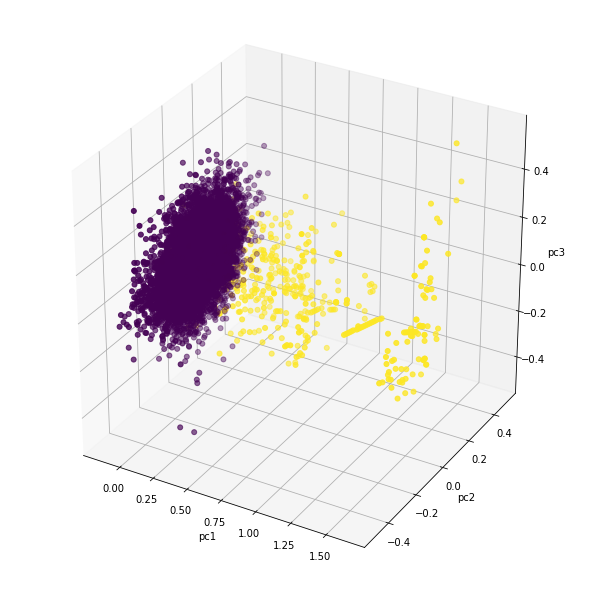

In [ ]:
def visual_data(df):
  y = df['Class']
  x = df[df.columns[0:28]]

  x = preprocessing.MinMaxScaler().fit_transform(x)
  pca = decomposition.PCA(n_components=3)
  pca_result = pca.fit_transform(x)
  print(pca.explained_variance_ratio_)
  
  pca_df = pd.DataFrame(data=pca_result, columns=['pc1', 'pc2', 'pc3'])
  pca_df = pd.concat([pca_df, pd.DataFrame({'label': y})], axis=1)

  ax = Axes3D(plt.figure(figsize=(8,8)))
  ax.scatter(xs=pca_df['pc1'], ys=pca_df['pc2'], zs=pca_df['pc3'], c=pca_df['label'], s=25)
  ax.set_xlabel("pc1")
  ax.set_ylabel("pc2")
  ax.set_zlabel("pc3")
  plt.show()

visual_data(test_data)



In [ ]:
normal_transactions.columns[0:28]

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')

### Task 1: Data preprocess

1. `Sample normalization`: Notice that columns (e.g. Amount column) in the datasets are in different scales. For autoencoder, since the loss is the reconstruction error, it's always necessary to normalize the data to avoid computation overflow of the error (i.e. approaching infinite). For example, variables can be normalized to a range between [0,1] through min_max normalization so that sigmoid activation can be used at the end and loss can be controled within a range. 
2. Split the traininng dataset into train and validation subsets so that you can use the validation dataset to control the train progress.
3. (optional) You can establish a baseline model using traditional approach, for example, KNN, T-SNE etc.

## Data Prep

In [ ]:
train_data, val_data = model_selection.train_test_split(normal_transactions, test_size=0.2)

scaler = preprocessing.MinMaxScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
val_data = scaler.transform(val_data)

n_features = train_data.shape[1]

# Add your code here

## Model

### Task 2: Anomaly detection by deep autoencoder

**Requirements**:
1. First, create a `deep autoencoder` as follows:
    - Create a deep encoder with at least 2 hidden layers in both encoder and decoder. 
    - For visualization, set the dimension of the bottleneck layer to 2 or 3
    - Train the autoencoder using the train/validation subsets
2. After training, reconstruct samples in the test dataset and calculate the `reconstruction error`.
3. Plot the histogram of the reconstruction errors of positive/negative classes in the test dataset
4. Choose an appropriate `threshold` and predict a sample is positive if its `construction error is greater than this threshold`.
5. Calculate precision, recall, f1, and ROC AUC score after you determine the threshold
6. Extract the `latent variables` in the bottleneck layer for the test samples, plot these variables in a scatter plot, and use different colors to differenitate samples in different classes.
7. Analysis:
    - Describe how you choose the hyperparameters, e.g. dimension of each layer, activation function, loss function etc.
    - Discuss whether you are able to differentiate samples from these two classes by reconstruction errors. What is the appropriate threshold?
    - From the scatter plot, do you think samples in both classes can be cleanly separated in the latent space?

Feel free to use the code in our lab material.

**Analysis:**
  - Describe how you choose the hyperparameters, e.g. dimension of each layer, activation function, loss function etc.
    - I chose Adam optimizer, and loss function as mse, I have used RELU as activation function since output is binary. I have tried a combination of hyperparameter to train the model and these were the parameters that gave the best results. To ov id overfitting I have given a dropout ration of 0.3
  - Discuss whether you are able to differentiate samples from these two classes by reconstruction errors. What is the appropriate threshold?
    - I was able to differentiate the samples from the two classes by claculating a treshold by computing the q-th quantile of the mean square error data
  - From the scatter plot, do you think samples in both classes can be cleanly separated in the latent space?
      - I could not seprate the samples in the latent space. The samples seem to ovrerlap and could be sperated. I have tried to plot a 3-D visualisation for the same as well.

In [ ]:
# Define deep autoencoder model

input_dim = train_data.shape[1]
BATCH_SIZE = 64
EPOCHS = 100

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation=activations.relu, input_shape=(input_dim, )), 
    tf.keras.layers.Dense(512, activation=activations.relu),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation=activations.relu),
    # tf.keras.layers.Dropout(0.3),
    # tf.keras.layers.Dense(8, activation=activations.relu),
    tf.keras.layers.Dense(3, activation=activations.relu),
    
    # reconstruction / decode
    tf.keras.layers.Dense(3, activation=activations.relu),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation=activations.relu),
    tf.keras.layers.Dense(input_dim, activation=activations.relu)
    
])

autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])

autoencoder.summary();


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 29)                870       
                                                                 
 dense_1 (Dense)             (None, 512)               15360     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
 dense_4 (Dense)             (None, 3)                 12        
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0

In [ ]:
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

# callbacks argument only takes a list
cb = [early_stop]

In [ ]:
# Compile and train model
history = autoencoder.fit(
    train_data, train_data,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(val_data, val_data)
)

# Add your code here


Epoch 1/100
3429/3429 [==============================] - 34s 10ms/step - loss: 0.0269 - acc: 0.9857 - val_loss: 0.0262 - val_acc: 0.9903
Epoch 2/100
3429/3429 [==============================] - 33s 10ms/step - loss: 0.0234 - acc: 0.9909 - val_loss: 0.0225 - val_acc: 0.9903
Epoch 3/100
3429/3429 [==============================] - 36s 11ms/step - loss: 0.0160 - acc: 0.9909 - val_loss: 0.0079 - val_acc: 0.9903
Epoch 4/100
3429/3429 [==============================] - 32s 9ms/step - loss: 0.0074 - acc: 0.9909 - val_loss: 0.0079 - val_acc: 0.9903
Epoch 5/100
3429/3429 [==============================] - 33s 10ms/step - loss: 0.0074 - acc: 0.9909 - val_loss: 0.0078 - val_acc: 0.9903
Epoch 6/100
3429/3429 [==============================] - 33s 10ms/step - loss: 0.0073 - acc: 0.9910 - val_loss: 0.0079 - val_acc: 0.9903
Epoch 7/100
3429/3429 [==============================] - 32s 9ms/step - loss: 0.0073 - acc: 0.9910 - val_loss: 0.0079 - val_acc: 0.9903
Epoch 8/100
3429/3429 [====================

In [ ]:
# Predict samples in the test dataset and calculate reconstruction errors
X_test_transformed = scaler.transform(X_test)
reconstructions = autoencoder.predict(X_test_transformed)
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)

In [ ]:
print(X_test.shape, mse.shape)

(10492, 29) (10492,)


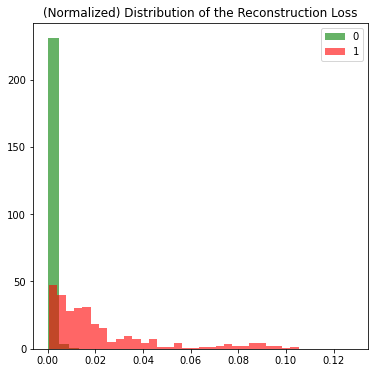

In [ ]:
# visualisations
# sns.set(rc={'figure.figsize': (15, 10) } )
# %matplotlib notebook

clean = mse[Y_test==0]
fraud = mse[Y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=30, density=True, label="0", alpha=.6, color="green")
ax.hist(fraud, bins=30, density=True, label="1", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

In [ ]:
encoder = tf.keras.models.Sequential(autoencoder.layers[:7])
encoder.summary()
RATIO_TO_FRAUD = 15
fraud = X_test_transformed[Y_test==1]
clean = X_test_transformed[Y_test==0][:len(fraud) * RATIO_TO_FRAUD ]

# combining arrays & building labels
features = np.append(fraud, clean, axis=0)
labels = np.append(np.ones(len(fraud)),
                   np.zeros(len(clean)))

# getting latent space representation
latent_representation = encoder.predict(features)

print(f'Clean transactions downsampled from {len(X_test_transformed[Y_test==0]):,} to {len(clean):,}.')
print('Shape of latent representation:', latent_representation.shape)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 29)                870       
                                                                 
 dense_1 (Dense)             (None, 512)               15360     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
 dense_4 (Dense)             (None, 3)                 12        
                                                                 
 dropout_1 (Dropout)         (None, 3)                

In [ ]:
latent_representation.shape

(7872, 3)

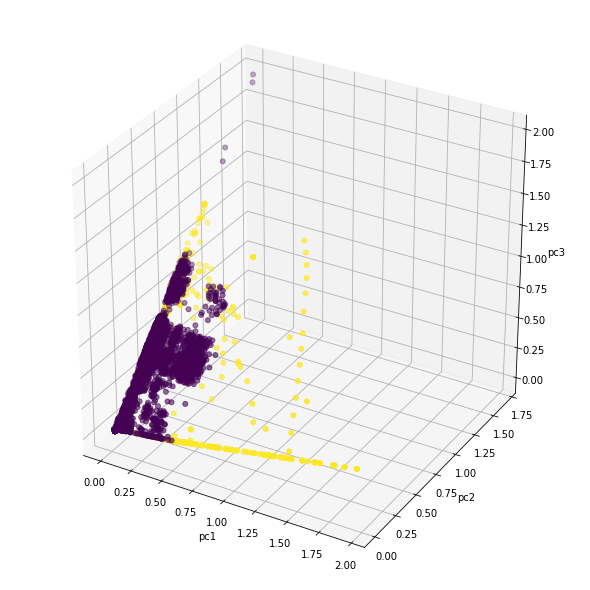

In [ ]:
X1 = latent_representation[:,0]
Y1 = latent_representation[:,1]
Z1 = latent_representation[:,2]

ax = Axes3D(plt.figure(figsize=(8,8)))
ax.scatter(xs=X1, ys=Y1, zs=Z1, c=labels, s=25)
ax.set_xlabel("pc1")
ax.set_ylabel("pc2")
ax.set_zlabel("pc3")
plt.show()

In [ ]:
from sklearn import metrics
cut_off = np.quantile(mse, .99)
# print(cut_off)
predications = mse > cut_off
print(metrics.classification_report(Y_test, predications))
print(f'Accuracy Score is {accuracy_score(Y_test, fraud)}')

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     10000
           1       0.99      0.21      0.35       492

    accuracy                           0.96     10492
   macro avg       0.98      0.61      0.66     10492
weighted avg       0.96      0.96      0.95     10492

Accuracy Score is 0.9781738467403737


### Task 3:  Anomaly detection by VAE

**Requirements**
1. Create a VAE model and complete Requirements (1)-(5) as stated in Task 2 
2. Use scatter plots to show the latent `mean` and `variance` produced by the latent layer for each class of samples in the test dataset. Do you think the latent layer is able to differentiate samples in these two classes? Could you explain why the mean and variance are distributed in such ways?
2. Compare the results you obtained in both models and comment on pros and cons of each model, e.g. performance, stability, robustness etc.

1. Use scatter plots to show the latent mean and variance produced by the latent layer for each class of samples in the test dataset. Do you think the latent layer is able to differentiate samples in these two classes? Could you explain why the mean and variance are distributed in such ways?
  - The reason to why the mean and variance is distributed in such a way us because instead of letting your neural network learn an arbitrary function, they learn the parameters of a probability distribution modeling your data.  You can generate new input data samples.

2. Compare the results you obtained in both models and comment on pros and cons of each model, e.g. performance, stability, robustness etc.
  - With autoencodes we are only doing a non-limnear PCA
  - if you want a precise control over your latent representations then VAE is better suited 
  - VAEs are better to learn latent representations. VAEs are known to give representations with disentangled factors, this happens due to Gaussian priors on the latent variables.
  - VAE are generative autoencoders, meaning they can generate new instances that look similar to original dataset used for training.
  - VAE learns probability distribution of the data whereas autoencoders learns a function to map each input to a number and decoder learns the reverse mapping.
  - Similar to how an AE generalizes simple dimensionality reduction techniques, such as Principle Component Analysis, by learning non-linear embeddings (representations) of data, VAE’s generalize this idea further by not only learning these embeddings but also how to create (new) instances as a result.

Reference: https://en.wikipedia.org/wiki/Generative_model

In [ ]:
from tensorflow.keras import backend as K
def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Define VAE model
original_dim = train_data.shape[1]
input_shape = (original_dim,)
# intermediate_dim = int(original_dim / 2)
intermediate_dim = 32
latent_dim = 2
tf.compat.v1.disable_eager_execution()

#encoder
inputs = tf.keras.layers.Input(shape=input_shape, name='encoder_input')

x = tf.keras.layers.Dense(intermediate_dim, activation='relu')(inputs) # change?
z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = tf.keras.layers.Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = tensorflow.keras.models.Model(inputs, z, name='encoder')
encoder.summary()

# Decoder
latent_inputs = tf.keras.layers.Input(shape=(latent_dim,), name='z_sampling')
x = tf.keras.layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = tf.keras.layers.Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = tensorflow.keras.models.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 29)]         0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 32)           960         ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 2)            66          ['dense_7[0][0]']                
                                                                                                  
 z_log_var (Dense)              (None, 2)            66          ['dense_7[0][0]']                
                                                                                            

In [ ]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [ ]:
# Compile and train VAE model
outputs = decoder(encoder(inputs))
vae_model = tensorflow.keras.models.Model(inputs, outputs, name='vae_mlp')

opt = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()

results = vae_model.fit(train_data, train_data,
                        shuffle=True,
                        epochs=100,
                        batch_size=512, validation_data=(val_data, val_data))
# Add your code here

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 29)]              0         
                                                                 
 encoder (Functional)        (None, 2)                 1092      
                                                                 
 decoder (Functional)        (None, 29)                1053      
                                                                 
Total params: 2,145
Trainable params: 2,145
Non-trainable params: 0
_________________________________________________________________
Train on 219452 samples, validate on 54863 samples
Epoch 1/100
215552/219452 [============================>.] - ETA: 0s - loss: 596.2337

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


219452/219452 [==============================] - 2s 8us/sample - loss: 592.3056 - val_loss: 379.8317
Epoch 2/100
219452/219452 [==============================] - 2s 7us/sample - loss: 211.9559 - val_loss: 91.1020
Epoch 3/100
219452/219452 [==============================] - 2s 7us/sample - loss: 52.7553 - val_loss: 39.6165
Epoch 4/100
219452/219452 [==============================] - 2s 7us/sample - loss: 37.4011 - val_loss: 35.8454
Epoch 5/100
219452/219452 [==============================] - 1s 7us/sample - loss: 34.8780 - val_loss: 34.1917
Epoch 6/100
219452/219452 [==============================] - 1s 7us/sample - loss: 33.5262 - val_loss: 33.0356
Epoch 7/100
219452/219452 [==============================] - 1s 7us/sample - loss: 32.5726 - val_loss: 32.3073
Epoch 8/100
219452/219452 [==============================] - 2s 7us/sample - loss: 31.9855 - val_loss: 31.8321
Epoch 9/100
219452/219452 [==============================] - 2s 7us/sample - loss: 31.5731 - val_loss: 31.4592
Epoch 10/1

In [ ]:
z.shape

TensorShape([None, 2])

In [ ]:
# Predict test samples and calculate reconstruction errors
X_train_pred = vae_model.predict(train_data)
# mae_vector = np.mean(abs(X_train_pred - train_data), axis=1)
mae_vector_normal = np.sqrt(np.mean((X_train_pred - train_data) ** 2, axis=1))
print(f'Avg error {np.mean(mae_vector_normal)}\nmedian error {np.median(mae_vector_normal)}\n99Q: {np.quantile(mae_vector_normal, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector_normal, 0.99)} ')

error_thresh = np.quantile(mae_vector_normal, 0.99)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Avg error 0.036349289886929044
median error 0.03424011679617442
99Q: 0.07226615763060179
setting threshold on 0.07226615763060179 


In [ ]:
X_pred = vae_model.predict(X_test_transformed)
mae_vector = np.mean(abs(X_pred - X_test_transformed), axis=1)
fraud = (mae_vector > error_thresh)
np.count_nonzero(fraud) / len(fraud)

0.02849790316431567

In [ ]:
print(classification_report(Y_test, fraud))
print(f'Accuracy Score is {accuracy_score(Y_test, fraud)}')

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10000
           1       0.94      0.57      0.71       492

    accuracy                           0.98     10492
   macro avg       0.96      0.78      0.85     10492
weighted avg       0.98      0.98      0.98     10492

Accuracy Score is 0.9781738467403737


Accuracy Score is 0.9781738467403737


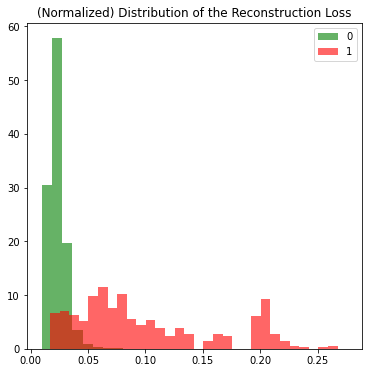

In [ ]:
clean = mae_vector[Y_test==0]
fraud = mae_vector[Y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=30, density=True, label="0", alpha=.6, color="green")
ax.hist(fraud, bins=30, density=True, label="1", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

In [ ]:
X_encoded = encoder.predict(X_test_transformed)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_transform = pca.fit_transform(X_encoded)


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


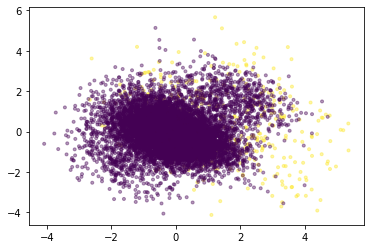

In [ ]:
z = X_transform
plt.scatter(z[:, 0], z[:, 1], c=Y_test, alpha=.4, s=3**2, cmap='viridis')
# if i > num_batches:
#   plt.colorbar()
#   plt.xlim((-4, 4))
#   plt.ylim((-4, 4))
#   break


In [ ]:
z.shape

(10492, 2)

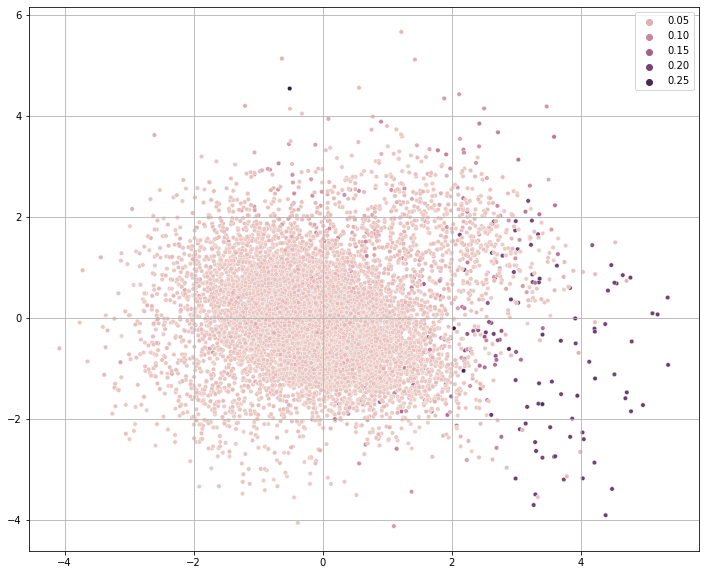

In [ ]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()